In [1]:
#env MODIS

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC

In [2]:
import pandas as pd

In [3]:
# Read dataset.
#os.chdir('/work/bb1036/b381362/dataset')
modis_file = 'MYD021KM.A2013122.1140.061.2018046032403.hdf'
DATAFIELD_NAME = 'EV_1KM_Emissive'
file = SD(modis_file, SDC.READ)

In [4]:
print(file.info())

datasets_dic = file.datasets()

for idx, sds in enumerate(datasets_dic.keys()):
    print(idx, sds)

(31, 58)
0 Latitude
1 Longitude
2 EV_1KM_RefSB
3 EV_1KM_RefSB_Uncert_Indexes
4 EV_1KM_Emissive
5 EV_1KM_Emissive_Uncert_Indexes
6 EV_250_Aggr1km_RefSB
7 EV_250_Aggr1km_RefSB_Uncert_Indexes
8 EV_250_Aggr1km_RefSB_Samples_Used
9 EV_500_Aggr1km_RefSB
10 EV_500_Aggr1km_RefSB_Uncert_Indexes
11 EV_500_Aggr1km_RefSB_Samples_Used
12 Height
13 SensorZenith
14 SensorAzimuth
15 Range
16 SolarZenith
17 SolarAzimuth
18 gflags
19 EV_Band26
20 EV_Band26_Uncert_Indexes
21 Band_250M
22 Band_500M
23 Band_1KM_RefSB
24 Band_1KM_Emissive
25 Noise in Thermal Detectors
26 Change in relative responses of thermal detectors
27 DC Restore Change for Thermal Bands
28 DC Restore Change for Reflective 250m Bands
29 DC Restore Change for Reflective 500m Bands
30 DC Restore Change for Reflective 1km Bands


In [5]:
# Subset data. check  https://hdfeos.org/zoo/index_openLAADS_Examples.php
#data = data_raw[0,:,:].astype(np.double)
#np.shape(data)

In [6]:
lat = file.select('Latitude')
latitude = lat[:,:]
lon = file.select('Longitude')
longitude = lon[:,:]

In [8]:
np.shape(lat), np.shape(lon)

((406, 271), (406, 271))

In [9]:
data_raw = file.select(DATAFIELD_NAME)

In [10]:
# Retrieve attributes.
attrs = data_raw.attributes(full=1) #because of full aditional dims, no really needed
lna=attrs["long_name"]
long_name = lna[0]
aoa=attrs["radiance_offsets"]
add_offset = aoa[0]
fva=attrs["_FillValue"]
_FillValue = fva[0]
sfa=attrs["radiance_scales"]
scale_factor = sfa[0]        
vra=attrs["valid_range"]
valid_min = vra[0][0]        
valid_max = vra[0][1]        
ua=attrs["radiance_units"]
units = ua[0]

(16, 2030, 1354)


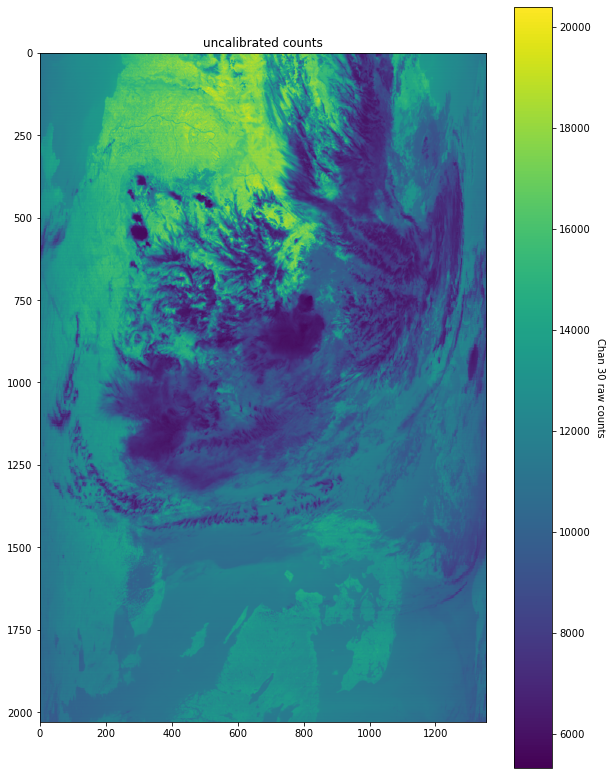

In [11]:
#Plot the channel 30 image
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(data_raw[9]) #channel 30
cax=fig.colorbar(CS)
ax.set_title('uncalibrated counts')
#
# add a label to the colorbar and flip it around 270 degrees
#
out=cax.ax.set_ylabel('Chan 30 raw counts')
out.set_verticalalignment('bottom')
out.set_rotation(270)
print(np.shape(data_raw))

In [12]:
# Retrieve dimension name.
#dim = data_raw.dim(0)
#dimname = dim.info()[0]
#print(dim,'\n',dimname)

In [13]:
longwave_bands = file.select('Band_1KM_Emissive')
longwave_bands.attributes()
band_nums=longwave_bands.get()
print(f'here are the modis channels in the emissive dataset \n{band_nums}')

here are the modis channels in the emissive dataset 
[20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]


In [14]:
data_correct = np.zeros(np.shape(data_raw))
np.shape(data_correct)

(16, 2030, 1354)

In [15]:
n_bands=len(band_nums)
for band in range(n_bands):
    data_correct[band] = (data_raw[band] - add_offset[band]) * scale_factor[band] 


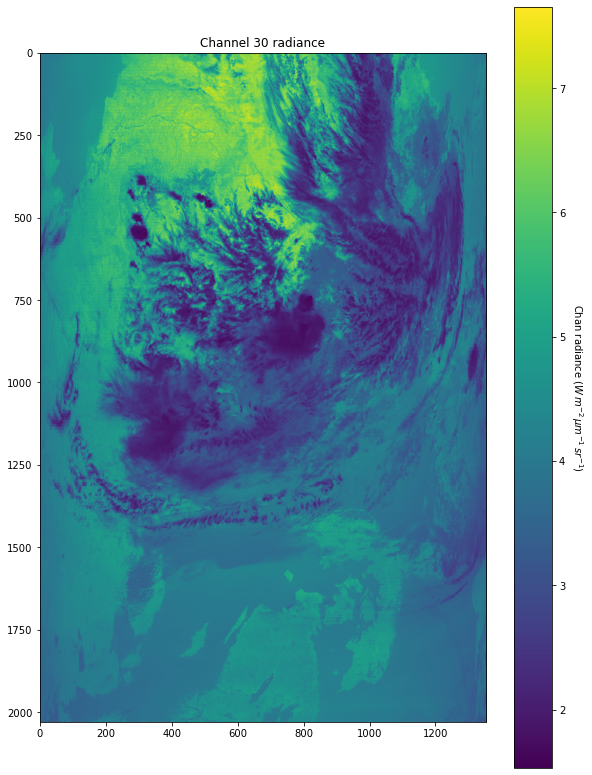

In [16]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(data_correct[9]) #channel 30
cax=fig.colorbar(CS)
ax.set_title('Channel 30 radiance')
#
# add a label to the colorbar and flip it around 270 degrees
#
out=cax.ax.set_ylabel('Chan radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1})$')
out.set_verticalalignment('bottom')
out.set_rotation(270)


In [17]:
# PCA

In [18]:
X_viz_train =data_correct

In [19]:
np.shape(X_viz_train)

(16, 2030, 1354)

In [20]:
n_bands=len(band_nums)


In [21]:
# Convert 2d band array in 1-d to make them as feature vectors and Standardization
#https://towardsdatascience.com/principal-component-analysis-in-depth-understanding-through-image-visualization-892922f77d9f
MB_matrix = np.zeros((X_viz_train[0,:,:].size,n_bands))
for i in range(n_bands):
    MB_array = X_viz_train[i,:,:].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd

In [22]:
print(np.shape(MB_matrix))


(2748620, 16)


In [23]:
# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigenvalues:\n\n", EigVal,"\n")

Eigenvalues:

 [1.300e+01 1.047e+00 9.797e-01 4.392e-01 3.049e-01 1.523e-01 2.475e-02
 2.131e-02 1.530e-02 7.126e-03 4.118e-03 1.279e-03 8.402e-04 2.217e-04
 3.097e-04 4.366e-04] 



In [24]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product

Text(0.5, 0.98, 'Pair plot of PCs')

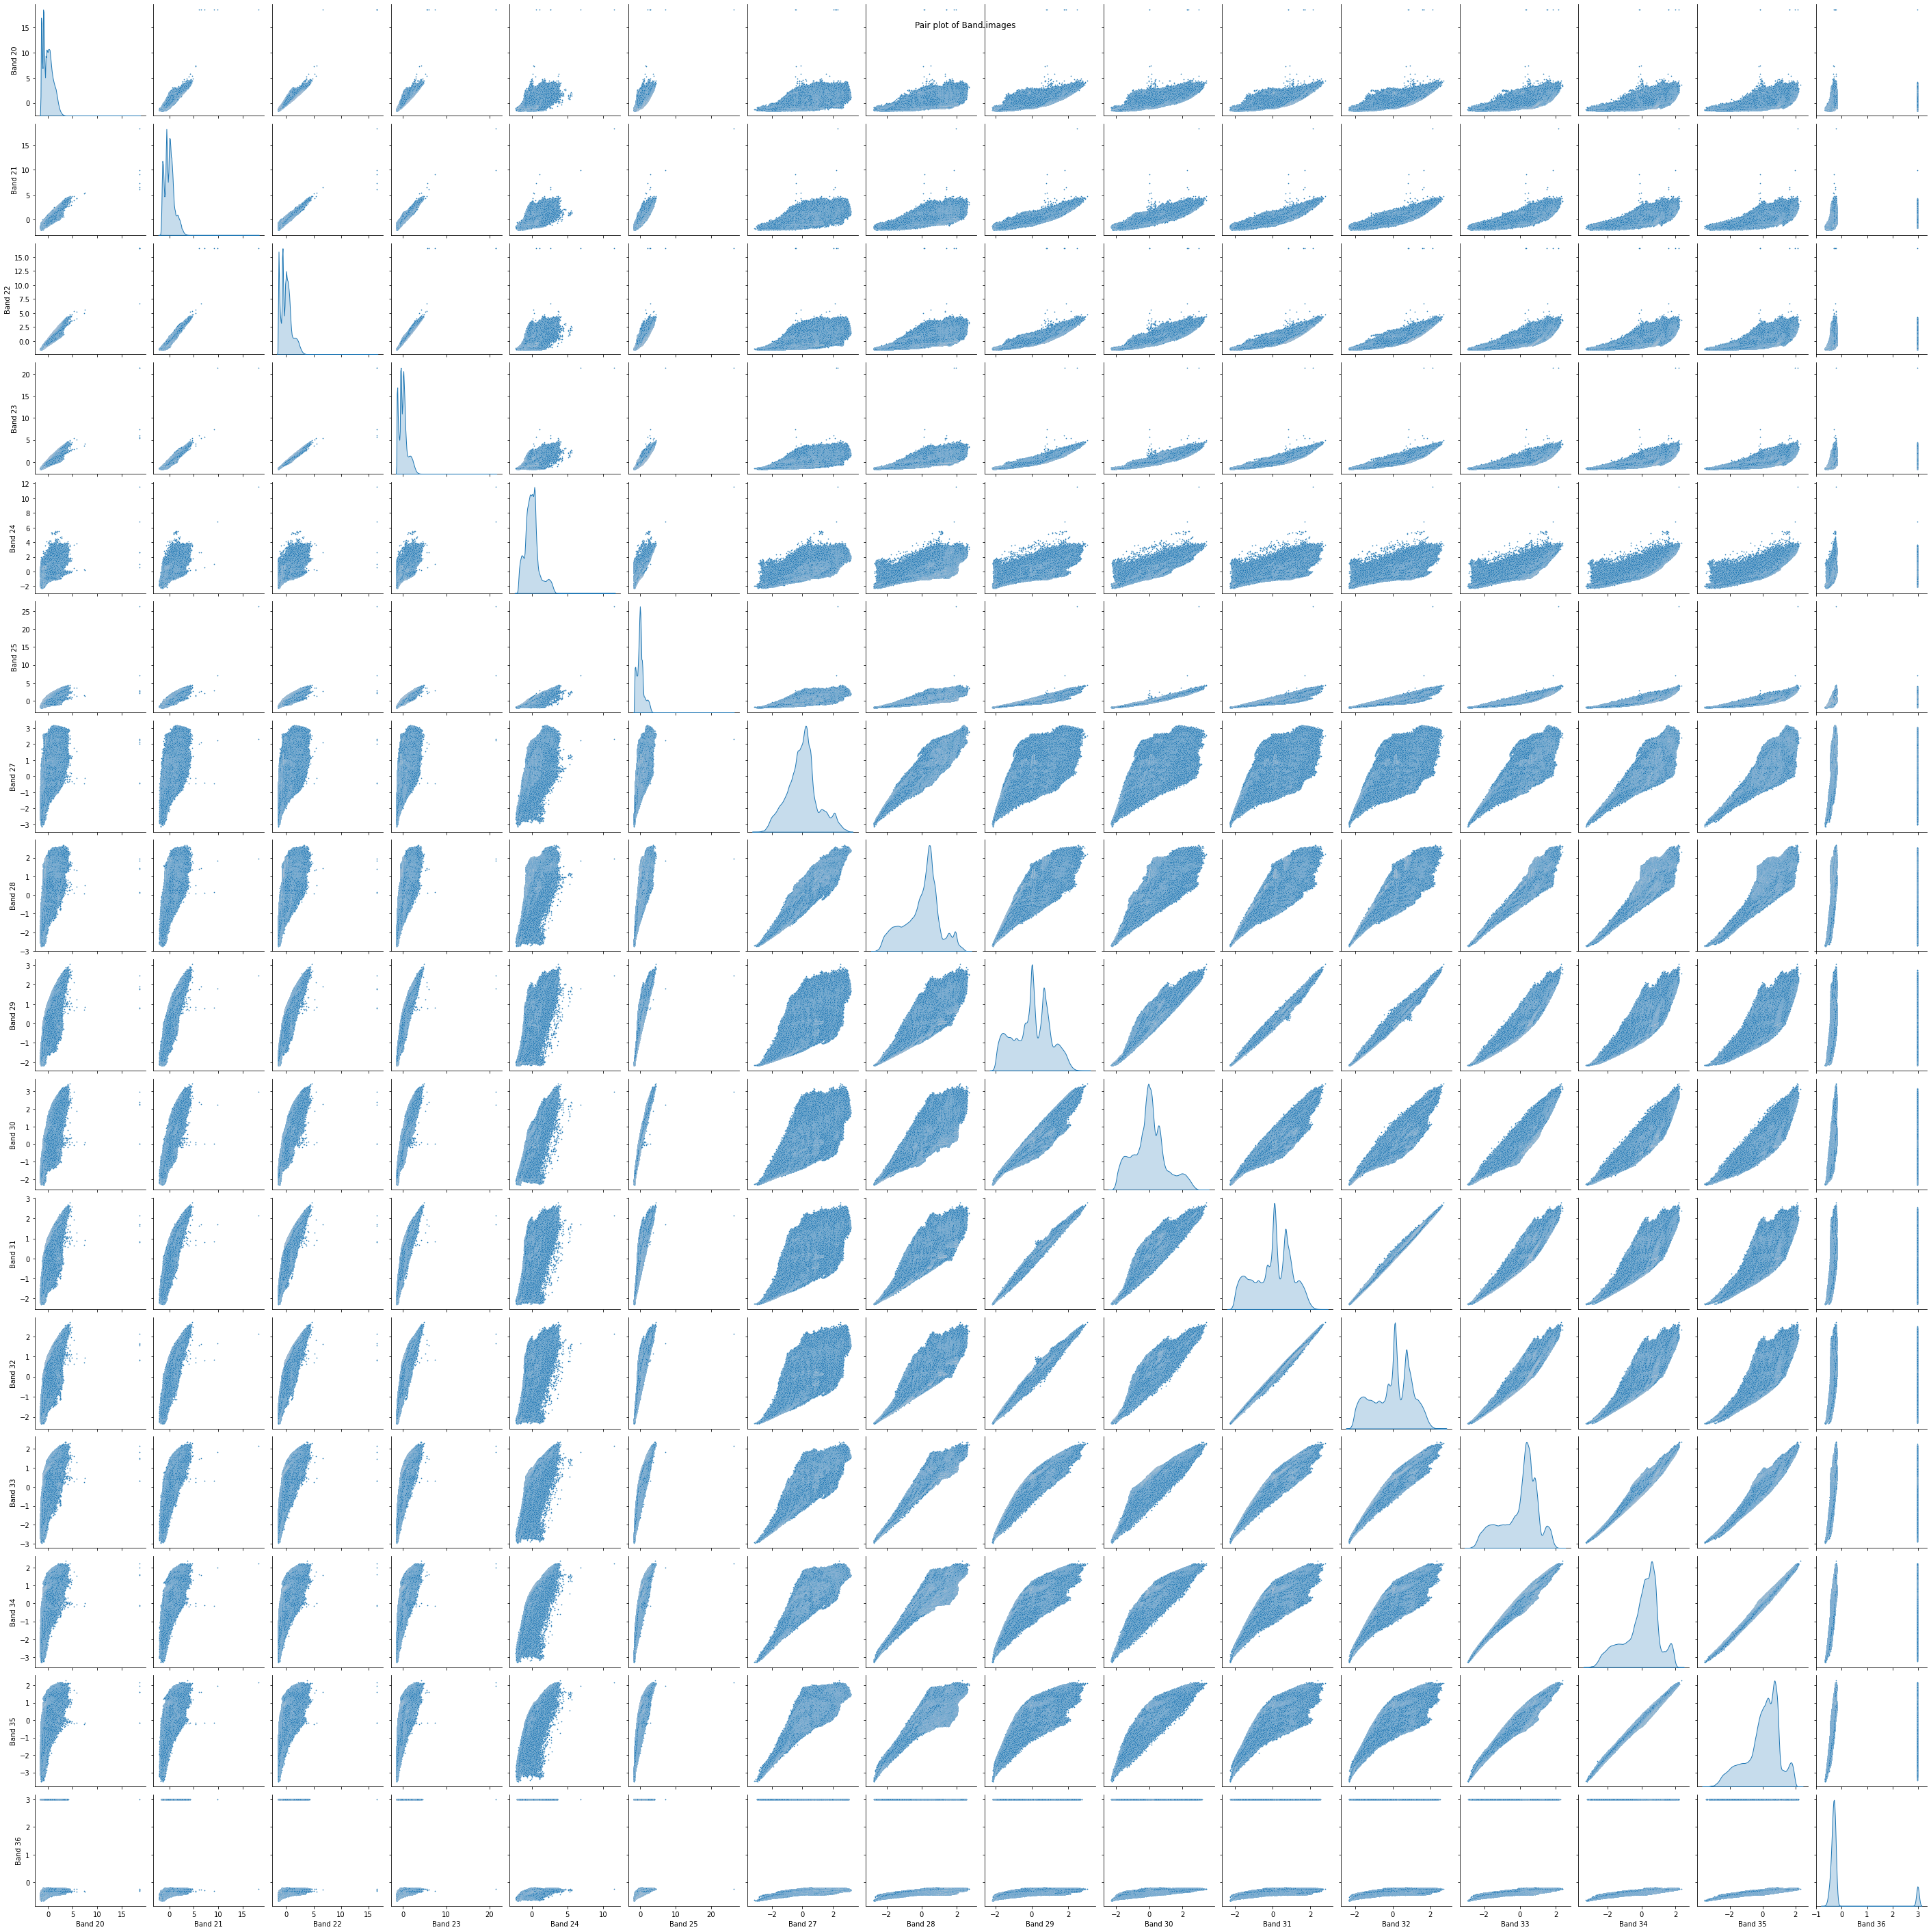

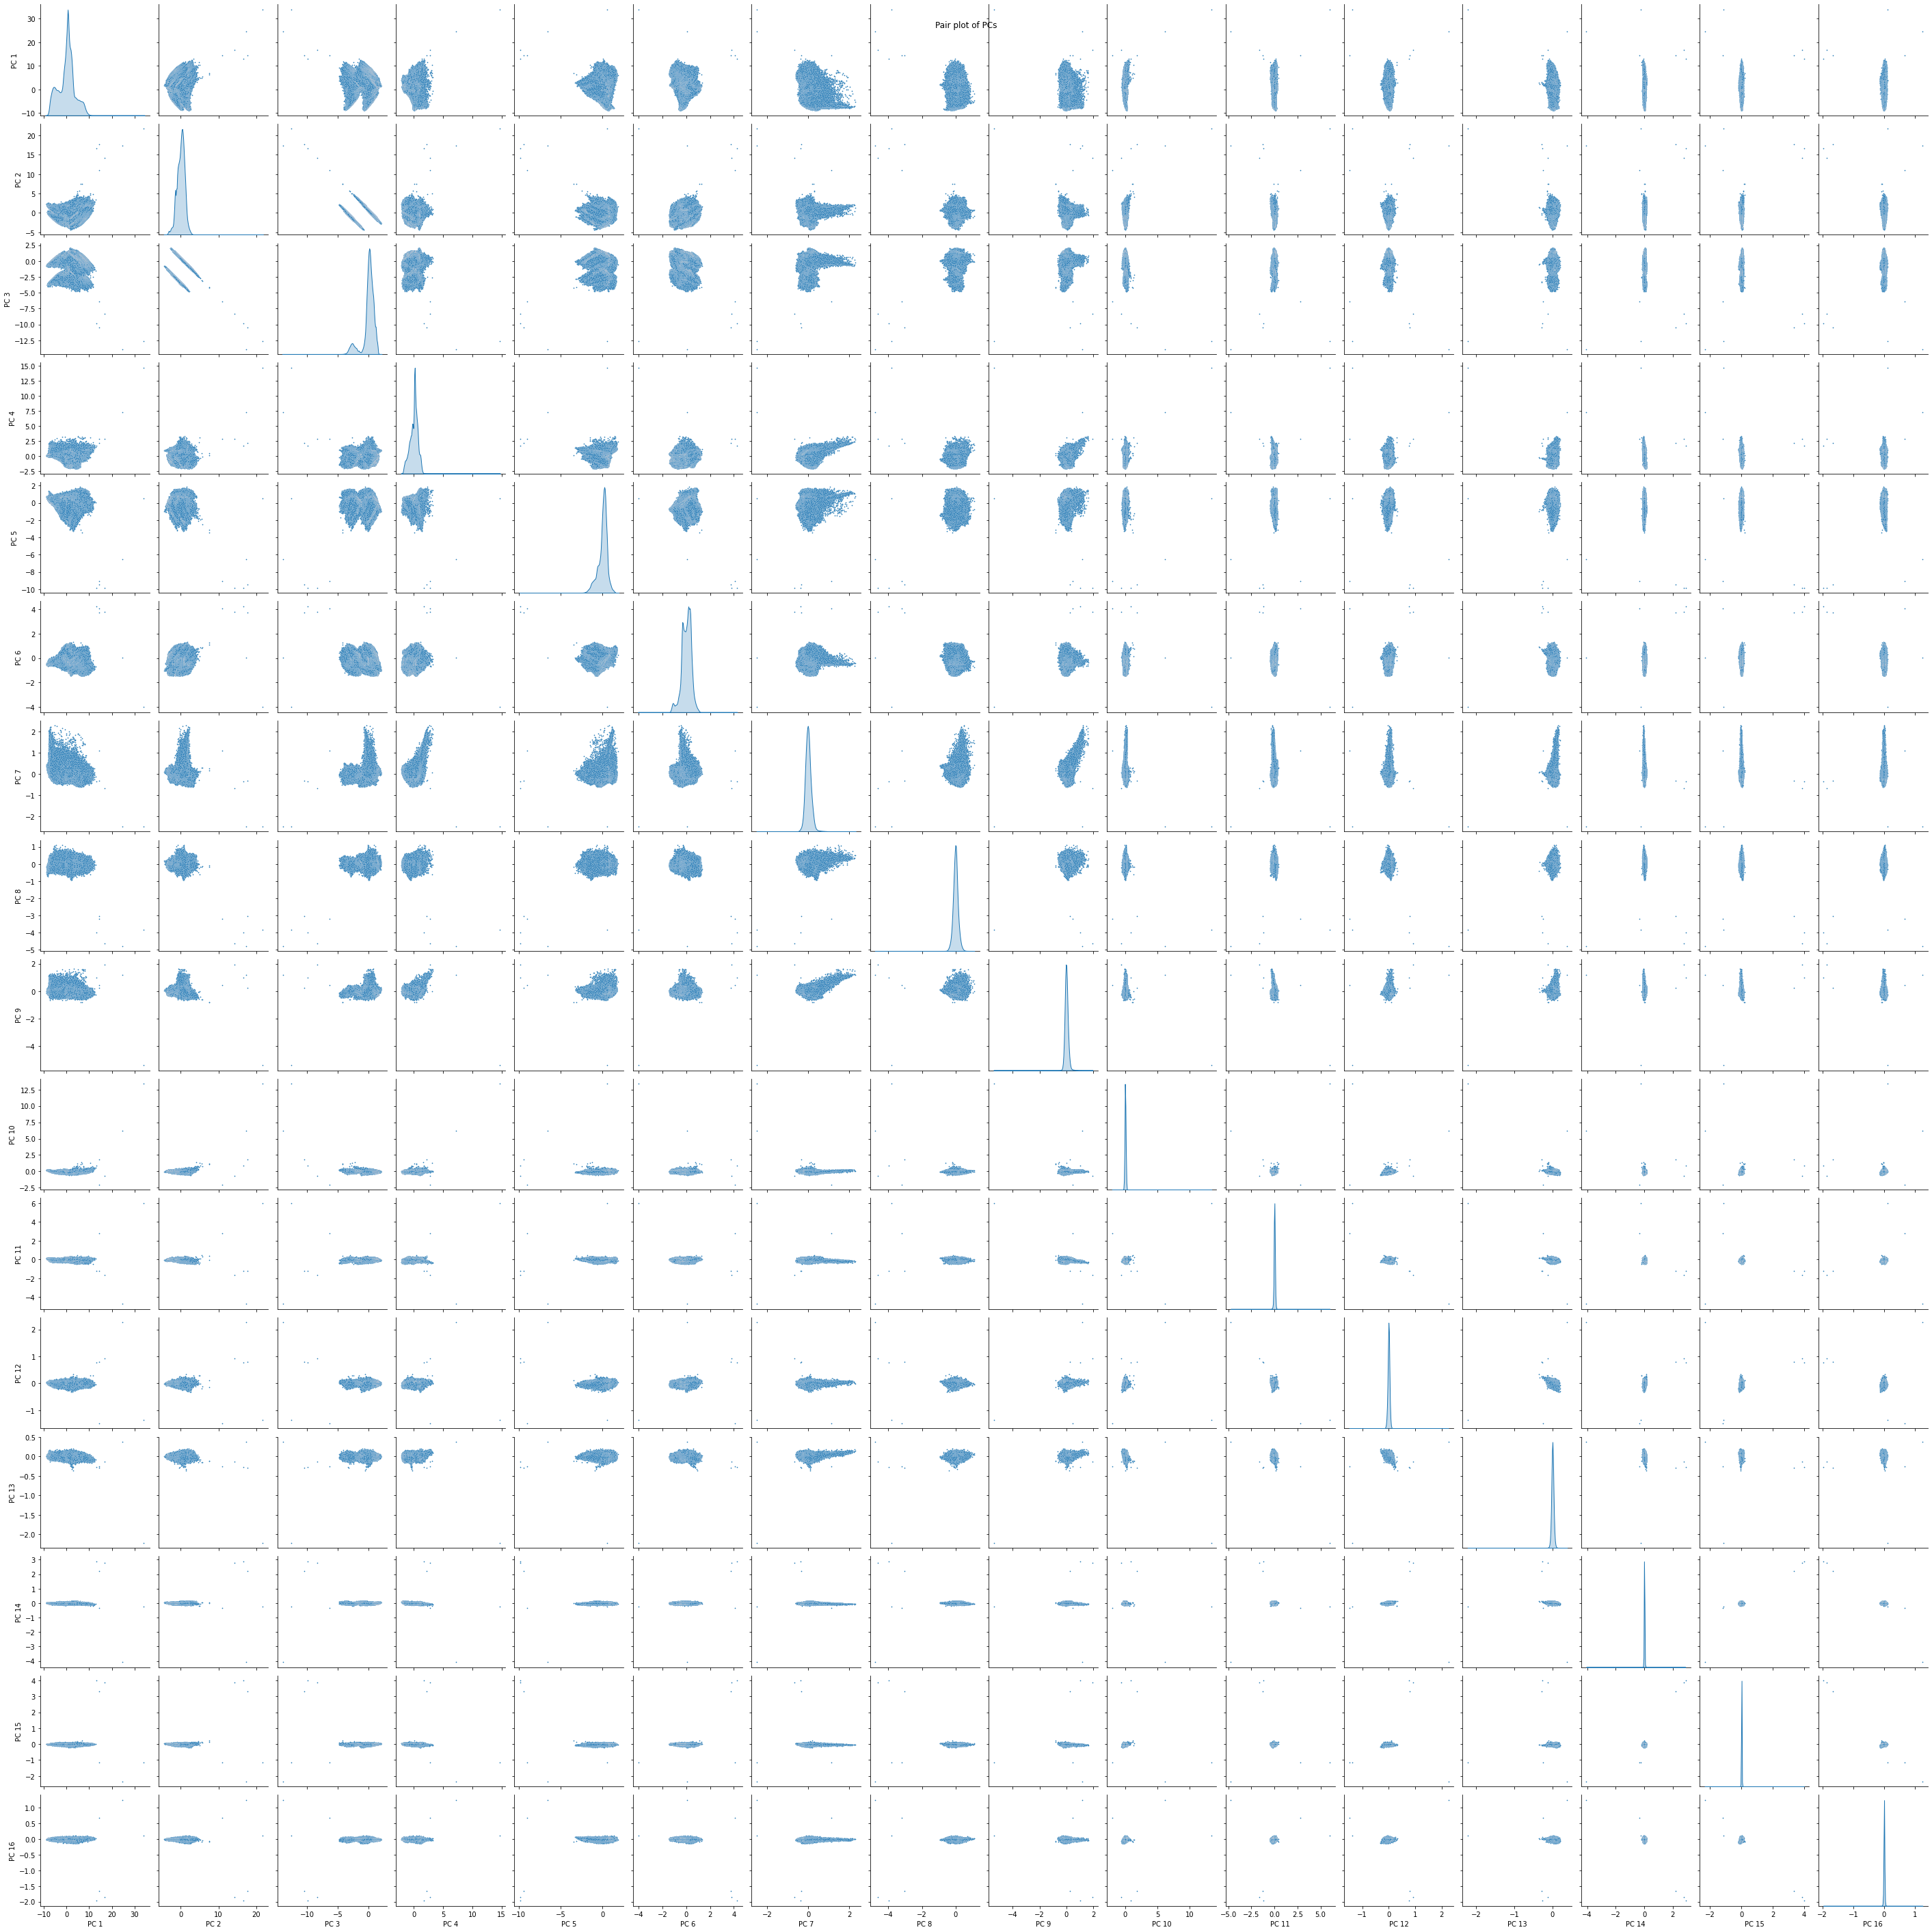

In [35]:
# Generate Paiplot for original data and transformed PCs
import seaborn as sns

Bandnames = ['Band 20','Band 21','Band 22','Band 23','Band 24','Band 25','Band 27','Band 28','Band 29','Band 30','Band 31','Band 32','Band 33','Band 34','Band 35','Band 36']
a = sns.pairplot(pd.DataFrame(MB_matrix,
                columns = Bandnames),
                 diag_kind='kde',plot_kws={"s": 3})
a.fig.suptitle("Pair plot of Band images")

PCnames = ['PC 1','PC 2','PC 3','PC 4','PC 5','PC 6','PC 7','PC 8','PC 9','PC 10','PC 11','PC 12','PC 13','PC 14','PC 15','PC 16']
b = sns.pairplot(pd.DataFrame(PC,
                columns = PCnames),
                 diag_kind='kde',plot_kws={"s": 3})
b.fig.suptitle("Pair plot of PCs")

In [36]:
#ISOMAP

In [40]:
np.shape(X_viz_train)  #real data lon 589, lAT 637

(16, 2030, 1354)

In [ ]:
X_subset=X_viz_train[:,:15,:15]
np.shape(X_subset)

In [ ]:
# Convert 2d band array in 1-d to make them as feature vectors and Standardization
#https://towardsdatascience.com/principal-component-analysis-in-depth-understanding-through-image-visualization-892922f77d9f
X = np.zeros((X_subset[0,:,:].size,n_bands))
for i in range(n_bands):
    MB_array = X_subset[i,:,:].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    X[:,i] = MB_arrayStd

In [ ]:
from sklearn.manifold import TSNE
from sklearn import manifold

##############
######
#ISOMAP
######
##############

iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(X)
manifold_iso_data = iso.transform(X)



In [ ]:
from sklearn.datasets import make_swiss_roll
n_samples = 10000
X, color = make_swiss_roll(n_samples)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.set_title('Here is the swiss roll maniflod', fontsize=10)
ax.scatter(X[:,0],X[:,1],X[:,2],c = color,cmap="Accent",s=60)
x = X[:,0][2:10000] 
y = X[:,1][2:10000] # Just as abovve, this time for column 1
ax.scatter(x,y,c = "black") #Now we randomly plot this in both 3D manifold (this may not be clearly visible as the  existing
ax.plot(x[2:4],y[2:4],c = "red")
ax = fig.add_subplot(2, 1, 2) 
#Now we plot 2D after ISOMAP...
ax.set_title('When compressing with ISOMAP', fontsize=10)
ax.scatter(manifold_iso_data[:,0],manifold_iso_data[:,1],c = color,cmap="Accent",s=60)
x = X[:,0][2:10000]#Now we plot the same 'black' samples, after ISOMAP in 2D and observe the distance in 2D.
y = X[:,1][2:10000]
ax.scatter(x,y,c = "black")
ax.plot(x[2:4],y[2:4],c = "red")
plt.show()

In [ ]:
#https://www.youtube.com/watch?v=g-Hb26agBFg

In [ ]:
#area germany, classificacion

In [2]:
!ncdump -v lon output-data_rttov_T12.nc

netcdf output-data_rttov_T12 {
dimensions:
	lon = 589 ;
	lat = 637 ;
	chan = 36 ;
variables:
	float lat(lat) ;
	float lon(lon) ;
	float Y(chan, lat, lon) ;
	float Y_clear(chan, lat, lon) ;
	float brdf(chan, lat, lon) ;
	float iwp_ret(lat, lon) ;
	float iwp_model(lat, lon) ;
	float g(lat, lon) ;
	float f(chan, lat, lon) ;
	float f_clear(chan, lat, lon) ;
data:

 lon = 4.5, 4.517, 4.534, 4.551, 4.568, 4.585, 4.602, 4.619, 4.636, 4.653, 
    4.67, 4.687, 4.704, 4.721, 4.738, 4.755, 4.772, 4.789, 4.806, 4.823, 
    4.84, 4.857, 4.874, 4.891, 4.908, 4.925, 4.942, 4.959, 4.976, 4.993, 
    5.01, 5.027, 5.044, 5.061, 5.078, 5.095, 5.112, 5.129, 5.146, 5.163, 
    5.18, 5.197, 5.214, 5.231, 5.248, 5.265, 5.282, 5.299, 5.316, 5.333, 
    5.35, 5.367, 5.384, 5.401, 5.418, 5.435, 5.452, 5.469, 5.486, 5.503, 
    5.52, 5.537, 5.554, 5.571, 5.588, 5.605, 5.622, 5.639, 5.656, 5.673, 
    5.69, 5.707, 5.724, 5.741, 5.758, 5.775, 5.792, 5.809, 5.826, 5.843, 
    5.86, 5.877, 5.894, 5.911, 5.928, 5.945

In [3]:
!ncdump -v lat output-data_rttov_T12.nc

netcdf output-data_rttov_T12 {
dimensions:
	lon = 589 ;
	lat = 637 ;
	chan = 36 ;
variables:
	float lat(lat) ;
	float lon(lon) ;
	float Y(chan, lat, lon) ;
	float Y_clear(chan, lat, lon) ;
	float brdf(chan, lat, lon) ;
	float iwp_ret(lat, lon) ;
	float iwp_model(lat, lon) ;
	float g(lat, lon) ;
	float f(chan, lat, lon) ;
	float f_clear(chan, lat, lon) ;
data:

 lat = 47.5, 47.511, 47.522, 47.533, 47.544, 47.555, 47.566, 47.577, 47.588, 
    47.599, 47.61, 47.621, 47.632, 47.643, 47.654, 47.665, 47.676, 47.687, 
    47.698, 47.709, 47.72, 47.731, 47.742, 47.753, 47.764, 47.775, 47.786, 
    47.797, 47.808, 47.819, 47.83, 47.841, 47.852, 47.863, 47.874, 47.885, 
    47.896, 47.907, 47.918, 47.929, 47.94, 47.951, 47.962, 47.973, 47.984, 
    47.995, 48.006, 48.017, 48.028, 48.039, 48.05, 48.061, 48.072, 48.083, 
    48.094, 48.105, 48.116, 48.127, 48.138, 48.149, 48.16, 48.171, 48.182, 
    48.193, 48.204, 48.215, 48.226, 48.237, 48.248, 48.259, 48.27, 48.281, 
    48.292, 48.303, 48.314,